# 4. Red completamente conectada con PyTorch
Me basaré en el notebook que vimos en clase para este mismo conjunto de datos con una red ompletamente conectada y cambiaré algunas cosas.

En este ejercicio vamos a clasificar imágenes de ropa usando la ase de datos [FashionMNIST]. Para esto PyTorch también como en el ejemplo de los dígtos, nos provee de una clase.


### Carga de bibliotecas

In [18]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importamos bibliotecas:

In [19]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### Visualización y otros:

In [20]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
RROWS, COLS = 4, 8

# Para visualizar los datos:

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

# Para geenar los pseudoaleatorios desde una semilla y poder reproducir los resultados
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## Datos
La base de datos está compuesa por imágenes en escala de grises de 28 × 28 píxeles que contienen fotos de ropa (como se verá en la imagen más abajo).

In [21]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i].numpy().squeeze(), cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [22]:
trn_ds = torchvision.datasets.FashionMNIST(
    # directorio de datos
    root = './data/FashionMNIST',
    # subconjunto de entrenamiento
    train=True,
    # descargar el conjunto
    download = True,
    # convertimos a tensor
    transform = T.Compose([
        T.ToTensor()                                 
    ])
)

tst_ds = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = T.Compose([
        T.ToTensor()                                 
    ])
)


Una vez descargados los datos, vamos a visualizar un lote:

images[0] shape=torch.Size([1, 28, 28]) dtype=torch.float32


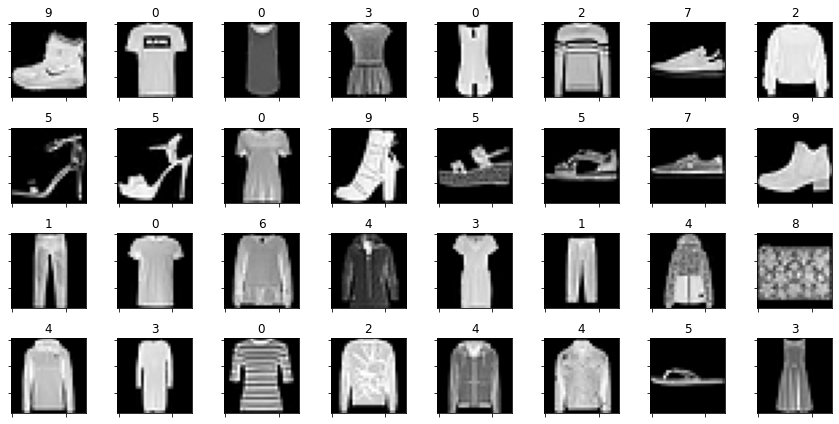

In [23]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = trn_ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

Creamos nuestros cargadores de datos:

In [24]:
#Para el conjunto de entrenamiento
trn_dl = DataLoader(
    # subconjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

#Para el subconjunto de prueba
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Modelos
Vamos a entrenar 3 variantes de arquitecturas:
1. La sugerida en la clase
2. Cambiando el número de neuronas de cada capa completamente conectada
3. Cambiando la función de activación por una ReLU

### 1: Reshape --> FC 128 --> Sigm --> FC 10 --> Softmax

In [25]:
# Modelo 1
class FCN1(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 2: Reshape --> FC 128 --> Sigm --> FC 64 --> Sigm --> FC 10 --> Softmax

In [26]:
# Modelo 2
class FCN2(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2, FC3 = 128, 64,10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),

            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),

            # fc2
            # [N, 128] => [N, 64]
            nn.Linear(FC1, FC2),
            nn.Sigmoid(),

            # fc3
            # [N, 64] => [N, 10]
            nn.Linear(FC2, FC3)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 3: Reshape --> FC 128 --> ReLU --> FC 10 --> Softmax

In [27]:
# Modelo 3
class FCN3(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),

            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            # fc2
            # [N, 64] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### Instanciamos e inspeccionamos los modelos:

Modelo 1

In [28]:
model1 = FCN1()
summary(model1, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN1                                     [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─Sigmoid: 2-3                      [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 10]
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

Modelo 2

In [29]:
model2 = FCN2()
summary(model2, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN2                                     [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─Sigmoid: 2-3                      [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 64]
│    └─Sigmoid: 2-5                      [1, 64]                   [1, 64]
│    └─Linear: 2-6                       [1, 64]                   [1, 10]
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.44
Estimated Total Size (MB): 0.44

Modelo 3

In [30]:
model3 = FCN3()
summary(model3, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN3                                     [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─ReLU: 2-3                         [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 10]
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## Entrenamiento

Para los tres modelos vamos a usar una tasa de aprendizae de $1\times 10^{-3}$ y 30 épocas

In [31]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=30,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos los modelos:

In [ ]:
# instanciamos un modelo
#model1 = FCN1()
# entrenamos
loss_hist1, acc_hist1 = train(model1, trn_dl, tst_dl)
print('Terminé mdelo 1')
loss_hist2, acc_hist2 = train(model2, trn_dl, tst_dl)
print('Terminé mdelo 2')
loss_hist3, acc_hist3 = train(model3, trn_dl, tst_dl)
print('Terminé mdelo 3')

  0%|          | 0/30 [00:00<?, ?it/s]

E00 loss=[219.02,219.08] acc=[55.95,54.92]
E01 loss=[204.96,205.07] acc=[62.21,61.72]
E02 loss=[187.22,187.39] acc=[61.52,60.76]
E03 loss=[168.90,169.16] acc=[63.28,62.60]
E04 loss=[152.98,153.33] acc=[64.08,63.59]
E05 loss=[140.06,140.49] acc=[65.92,65.36]
E06 loss=[129.66,130.20] acc=[68.02,67.61]
E07 loss=[121.20,121.80] acc=[69.27,68.79]
E08 loss=[114.19,114.89] acc=[70.19,69.76]
E09 loss=[108.31,109.04] acc=[70.64,70.29]
E10 loss=[103.34,104.12] acc=[71.41,70.82]
E11 loss=[ 99.07, 99.89] acc=[71.72,71.07]
E12 loss=[ 95.39, 96.31] acc=[72.21,71.45]
E13 loss=[ 92.19, 93.17] acc=[72.59,71.67]
E14 loss=[ 89.37, 90.35] acc=[72.90,72.09]
E15 loss=[ 86.90, 87.94] acc=[73.05,72.13]
E16 loss=[ 84.69, 85.76] acc=[73.28,72.47]
E17 loss=[ 82.72, 83.81] acc=[73.61,72.97]
E18 loss=[ 80.96, 82.14] acc=[73.76,73.11]
E19 loss=[ 79.35, 80.52] acc=[74.04,73.54]
E20 loss=[ 77.91, 79.15] acc=[74.26,73.65]
E21 loss=[ 76.59, 77.86] acc=[74.42,73.70]
E22 loss=[ 75.38, 76.62] acc=[74.55,73.89]
E23 loss=[ 

  0%|          | 0/30 [00:00<?, ?it/s]

E00 loss=[230.01,230.00] acc=[10.00,10.01]
E01 loss=[229.75,229.75] acc=[21.28,21.47]
E02 loss=[229.50,229.50] acc=[15.42,15.32]
E03 loss=[229.24,229.24] acc=[20.37,20.61]
E04 loss=[228.94,228.94] acc=[24.70,24.74]
E05 loss=[228.59,228.59] acc=[40.73,40.90]
E06 loss=[228.21,228.21] acc=[37.30,36.96]
E07 loss=[227.74,227.74] acc=[47.25,46.52]
E08 loss=[227.19,227.19] acc=[40.34,39.60]
E09 loss=[226.50,226.50] acc=[45.69,46.17]
E10 loss=[225.64,225.65] acc=[42.31,41.58]
E11 loss=[224.55,224.56] acc=[46.00,45.63]
E12 loss=[223.14,223.15] acc=[55.23,55.48]
E13 loss=[221.29,221.30] acc=[49.80,49.76]
E14 loss=[218.81,218.82] acc=[47.55,46.94]
E15 loss=[215.49,215.51] acc=[47.99,47.59]
E16 loss=[211.06,211.08] acc=[47.49,47.28]
E17 loss=[205.37,205.41] acc=[45.03,44.94]
E18 loss=[198.48,198.55] acc=[45.51,45.76]


### Gráficas de pérdidas y exactitud

In [ ]:
trn_loss1, tst_loss1 = zip(*loss_hist1)
plt.plot(trn_loss1, 'tab:orange', label='trn loss 1')
plt.plot(tst_loss1, 'tab:red', label='tst loss 1')

trn_loss2, tst_loss2 = zip(*loss_hist2)
plt.plot(trn_loss2, 'tab:blue', label='trn loss 2')
plt.plot(tst_loss2, 'tab:purple', label='tst loss 2')

trn_loss3, tst_loss3 = zip(*loss_hist3)
plt.plot(trn_loss3, 'tab:green', label='trn loss 3')
plt.plot(tst_loss3, 'tab:brown', label='tst loss 3')

plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

In [ ]:
trn_acc1, tst_acc1 = zip(*acc_hist1)
plt.plot(trn_acc1, 'tab:orange', label='trn acc 1')
plt.plot(tst_acc1, 'tab:red', label='tst acc 1')

trn_acc2, tst_acc2 = zip(*acc_hist2)
plt.plot(trn_acc2, 'tab:blue', label='trn acc 2')
plt.plot(tst_acc2, 'tab:purple', label='tst acc 2')

trn_acc3, tst_acc3 = zip(*acc_hist2)
plt.plot(trn_acc3, 'tab:green', label='trn acc 3')
plt.plot(tst_acc3, 'tab:brown', label='tst acc 3')

plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## Evaluación final
Para evaluar el sesempeño final de nuestros modelos, una vez entrenados vemos qué tal les va en el conjunto de prueba

In [ ]:
tst_loss1, tst_acc1 = eval_epoch(tst_dl, model1)
tst_loss2, tst_acc2 = eval_epoch(tst_dl, model2)
tst_loss3, tst_acc3 = eval_epoch(tst_dl, model3)
print(f'loss1 =[{tst_loss1:6.2f}] '
      f'acc1 =[{tst_acc1:5.2f}]\n'
      f'loss2 =[{tst_loss2:6.2f}] '
      f'acc2 =[{tst_acc2:5.2f}]\n'
      f'loss3 =[{tst_loss3:6.2f}] '
      f'acc3 =[{tst_acc3:5.2f}]')

### Inferencia

In [ ]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts1 = model1(x)
    y_prob1 = F.softmax(y_lgts1, 1)
    y_pred1 = torch.argmax(y_prob1, 1)

    y_lgts2 = model2(x)
    y_prob2 = F.softmax(y_lgts2, 1)
    y_pred2 = torch.argmax(y_prob2, 1)

    y_lgts3 = model3(x)
    y_prob3 = F.softmax(y_lgts3, 1)
    y_pred3 = torch.argmax(y_prob3, 1)

    titles = [f'V={t} P1={p2} P2={p3} P3={p3}' for t, p1, p2, p3 in zip(y_true, y_pred1, y_pred2, y_pred3)]
    display_batch(x, titles, 8, 4)